# Simple pyPamtra2 example

Note that Fortran output cannot be seen from a jupyter notebook. For debugging Fortran modules, run this notebook from the ipython terminal with '%run notebookname.pynb'

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pn



import pyPamtra2


try:
    %matplotlib inline
except:
    pass



We can have an abritrary number of helper dimensions

In [2]:
additionalDims = OrderedDict()
additionalDims['time'] = pn.date_range('2016-01-01','2016-01-05',freq='D')[:1]
# additionalDims['hair_color'] = ['red','brown','black']
# additionalDims['lat'] = np.arange(70,80)
# additionalDims['lon'] = np.arange(170,180,2)

Create the pyPamtra2 object

In [3]:
pam2 = pyPamtra2.pyPamtra2(
    hydrometeors=['liquid','ice'], # list of names 
    nPeaks = 1, #for which moments are estimated
    nHydroBins=99, 
    nFFT=512,
    additionalDims = additionalDims)


fallVelocityRelation


modify settings

In [4]:
pam2.settings

{'fallVelocityRelation': 'khvorostyanov01_spheres',
 'general': {'verbosity': 0},
 'radarProperties': {35.5: {'fwhrBeamwidthDeg': 0.31,
   'integrationTime': 1.4,
   'k2': 0.92,
   'maxV': 7.885,
   'minV': -7.885,
   'nAve': 150,
   'pNoise1000': -32.23,
   'smoothSpectrum': True}},
 'radarSimulator': {'aliasingNyquistInterv': 1, 'randomSeed': 0}}

In [5]:
pam2.settings['general']['verbosity'] = 10
pam2.settings['radarSimulator']['randomSeed'] = 5
pam2.settings['radarSimulator']['aliasingNyquistInterv'] = 1
pam2.settings['radarProperties'][35.5]['nAve'] = 25



 it's a modified dict, so you cannot add keys on your own (or by accident)

In [6]:
pam2.settings['general']['test'] = 10

ValueError: Frozen dictionary does not contain key test

Start with the atmospheric data

In [7]:
pam2.data.eddyDissipationRate.values[:] = 1e-4
pam2.data.horizontalWind.values[:] = 10
pam2.data.verticalWind.values[:] = 0
pam2.data.temperature.values[:] = 300
pam2.data.pressure.values[:] = 10000
pam2.data.height.values[:] = 1000



add the liquid hydrometeor description. monodisperse distribution (at least almost, we still need Dmin and Dmax)

In [8]:

pam2.addHydrometeorProperties(
    0, #hydrometeor index or name
    [1e-5,2e-5], # Dmin and DMax
    10**7, #N(D)
    psdNormalized = False, #PSD normalized by bins?
    )



the same for ice. Here the PSD is estmated by the function pyPamtra2.sizeDistributions.exponential, the parameters are provided by psdFuncArgs (could be arrays, too!)

In [9]:
pam2.addHydrometeorProperties(
    'ice',#hydrometeor index or name
    [1e-5,6e-4],# Dmin and DMax
    pyPamtra2.sizeDistributions.exponential, #this is the function for the psd
    psdFuncArgs = [100,400], # with these arguments, corresponding to N0 and lambda
    psdNormalized = True,
    mass_size_a = 0.0121, #mass size relation (Brown and Freancis) 
    mass_size_b = 1.9,
    area_size_a = 0.02, #area size relation (random)
    area_size_b = 1.4,
)


now we have all variables together, let's run the model

estimate the broadening of the radar Doppler spectrum

In [10]:
pam2.getSpectralBroadening()

decorating calcSpectralBraodening 0 0 [0, 1, 2] [0]
in 0 (1, 1) (1,) (1, 1) False
in 1 (1, 1) (1,) (1, 1) False
in 2 (1, 1) (1,) (1, 1) False
out 0 (1,) (1, 1) (1, 1)


estimate the refractive index (alibi function as of now!)

In [11]:
pam2.getRefractiveIndex()

scattering properties

In [12]:
pam2.getScattering(method='Rayleigh')

decorating rayleigh 0 1 [0, 1] [0]
in 0 (1, 1, 99) (1, 99) (1, 1) False
in 1 (1, 1) (1,) (1, 1) False
out 0 (1, 99) (1, 1, 99) (1, 1)
decorating rayleigh 0 1 [0, 1] [0]
in 0 (1, 1, 99) (1, 99) (1, 1) False
in 1 (1, 1) (1,) (1, 1) False
out 0 (1, 99) (1, 1, 99) (1, 1)


estimate path integrated attenuation (alibi function! returns 0!) 

In [13]:
pam2.getPIA()



now estimate the radar Doppler spectrum

(There is a numerical issue caused by the convolution of turbulence: You can test it by increasing N0 of the snow PSD)

decorating simulateRadarSpectrum 0 2 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] [0]
in 0 (1, 1, 2, 99) (1, 2, 99) (1, 1) False
in 1 (1, 1, 2, 99) (1, 2, 99) (1, 1) False
in 2 (1, 1, 2, 99) (1, 2, 99) (1, 1) False
in 3 (1, 1, 2, 99) (1, 2, 99) (1, 1) False
in 4 (1, 1, 2, 99) (1, 2, 99) (1, 1) False
in 5 (1, 1) (1,) (1, 1) False
in 6 (1, 1) (1,) (1, 1) False
in 7 (1, 1) (1,) (1, 1) False
in 8 (1, 1) (1,) (1, 1) False
in 9 (1, 1) (1,) (1, 1) False
in 10 (1, 1) (1,) (1, 1) False
out 0 (1, 512) (1, 1, 512) (1, 1)


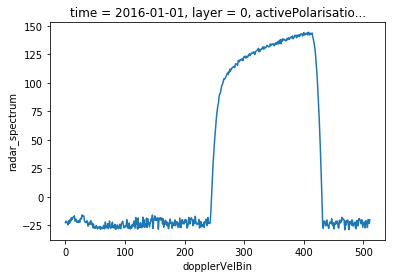

In [14]:

pam2.getRadarSpectrum()

(10*np.log10(pam2.results.radar_spectrum)).plot()
plt.show()



Estimate the moments of the radar Doppler spectrum 

In [15]:
pam2.getRadarMoments()

10*np.log10(pam2.results.reflectivity)




<xarray.DataArray 'reflectivity' (time: 1, layer: 1, frequency: 1, activePolarisation: 1, dopplerPeak: 1)>
array([[[[[ 22.018293]]]]])
Coordinates:
  * time                (time) datetime64[ns] 2016-01-01
  * layer               (layer) int64 0
  * activePolarisation  (activePolarisation) <U2 'NN'
  * frequency           (frequency) float64 35.5
  * dopplerPeak         (dopplerPeak) int64 0